In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip3 install --quiet -U fireflyai


Mounted at /content/drive


In [7]:
#@title #Import firefly.ai library {display-mode: "form"}

import fireflyai as firefly
from fireflyai.version import __version__
print("Firefly SDK version {}".format(__version__))

import pandas as pd
import time, os, collections, getpass, pprint, urllib3

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn


Firefly SDK version 0.0.30


In [8]:
#@title #Login to Firefly platform 
#@markdown * Using authenticate(username, password)

USER = input("User:")
PASSWORD = getpass.getpass("Password:")
try:
    firefly.authenticate(username=USER, password=PASSWORD)
    print("{} - Login successful".format(USER))
except Exception as e:
    print(e)

User:yuv
Password:··········
yuv - Login successful


In [0]:
#@title #Example classification dataset UCI Car.
#@markdown * Example of full loop using dataset "UCI_Car" 
#@markdown * It is a classification task (multi-class) 

PATH="/content/drive/My Drive/Neural_shared/SDK/"

data_name='car_sdk_demo'

df = pd.read_csv(PATH+data_name+".csv")

In [10]:
#@title #Uploading a Data source
#@markdown * Use firefly.Datasource.create_from_dataframe to upload a Dataframe
#@markdown * Use firefly.Datasource.create to upload a CSV file

#@markdown * wait=True ----> wait until the upload and analysis of the data is completed. 
#@markdown * wait=False -----> return immediately 

try:
    source_id = firefly.Datasource.create_from_dataframe(df=df, 
                                   data_source_name=data_name, 
                                   wait=True, skip_if_exists=True)['id']
    print ("\nYour Source ID for {} is: {}".format(data_name, source_id))
except Exception as e:
    print(e)



Your Source ID for car_sdk_demo is: 4348


In [11]:
#@title #Getting the list of uploaded data sources
#@markdown * Use firefly.list_datasources() 

list_sources = firefly.Datasource.list()
sources = pd.DataFrame(list_sources['hits'])

sources[[ 'creation_date', 'data_size',  'id',
        'name', 'row_count', 'state',]].head(10)

,creation_date,data_size,id,name,row_count,state
0,2020-01-01T09:26:06,0.041515,4527,openml_car_test.csv,1729.0,AVAILABLE
1,2019-12-31T09:25:44,0.044983,4523,openml_car.csv,1729.0,AVAILABLE
2,2019-12-16T12:46:41,0.230258,4469,ABB_TimeSeries_Forecasting_train_subsampled_h.csv,6721.0,AVAILABLE
3,2019-12-13T06:09:11,6.761950,4458,Firefly_Maintpartner_Test_12DEC2019.csv,41410.0,AVAILABLE
4,2019-12-10T07:47:17,0.065379,4440,Data4TS4Firefly.csv,1605.0,AVAILABLE
5,2019-12-10T07:46:16,0.056405,4439,car_sdk_demo_test.csv,1729.0,AVAILABLE
6,2019-12-03T12:35:27,0.189938,4419,ABB_TimeSeries_Forecastingsubsampled.csv,6721.0,AVAILABLE
7,2019-12-02T12:47:36,0.029481,4417,sinus.csv,1001.0,AVAILABLE
8,2019-12-01T07:20:09,0.215248,4410,ABB_TimeSeries_Forecasting.csv,9673.0,AVAILABLE
9,2019-11-25T07:06:33,0.064102,4389,Populus_Firefly_Data_labeled.csv,250.0,AVAILABLE


In [12]:
#@title # Preparing a Dataset
#@markdown # In this step we will define the Target and the task-type:

data_set_name = data_name


target = 'class' #@param {type:'string'}

#@markdown # Select Machine learning task-type:

#@markdown * Regression
#@markdown * Classification
#@markdown * Anomaly Detection
#@markdown * Time-series Regression/Classification

Task_Type_select = 'firefly.enums.ProblemType.CLASSIFICATION' #@param['firefly.enums.ProblemType.REGRESSION', 'firefly.enums.ProblemType.CLASSIFICATION', 'firefly.enums.ProblemType.ANOMALY_DETECTION']
Task_Type = eval(Task_Type_select)
print ('Your selected Target (y_value) is:', target)
print ('Task Type is:', Task_Type.value)

#@markdown # Use firefly.firefly.Datasource.prepare_data()

try:
    dataset_id = firefly.Datasource.prepare_data( 
                    datasource_id=source_id, 
                    dataset_name=data_set_name,
                    target=target, 
                    # header=True,
                    problem_type=Task_Type,
                    sample_id=['car_id'],
                    retype_columns={'car_id': firefly.enums.FeatureType.CATEGORICAL},
                    wait=True, skip_if_exists=True)['id']
    print("Dataset {} id is {}".format( data_set_name, dataset_id))
except Exception as e:
    print(e)
    


Your selected Target (y_value) is: class
Task Type is: classification
Dataset car_sdk_demo id is 5389


In [13]:
#@title # List the datasets 
#@markdown * use firefly.Dataset.list()

list_datasets = firefly.Dataset.list()
datasets = pd.DataFrame(list_datasets['hits'])
datasets.set_index('creation_date')
datasets[[ 'creation_date',  'id', 'name',  'problem_type', 'row_count', 'state']].head(10)


,creation_date,id,name,problem_type,row_count,state
0,2019-12-31T09:26:24,5655,openml_car,classification,1728.0,AVAILABLE
1,2019-12-17T07:30:07,5579,Maintpartner_Test_12DEC2019 TRGT (no time),regression,41409.0,AVAILABLE
2,2019-12-16T14:59:26,5577,Firefly_Maintpartner_Test_12DEC2019 TRGT (v1),regression,41409.0,AVAILABLE
3,2019-12-16T12:52:10,5576,ABB_TimeSeries_Forecasting_h,regression_timeseries,6720.0,AVAILABLE
4,2019-12-13T06:10:55,5557,Firefly_Maintpartner_Test_12DEC2019 WGHT,regression,41409.0,AVAILABLE
5,2019-12-13T06:10:12,5556,Firefly_Maintpartner_Test_12DEC2019 TRGT,regression,41409.0,AVAILABLE
6,2019-12-10T07:48:43,5537,Data4TS4Firefly,regression_timeseries,1604.0,AVAILABLE
7,2019-12-04T10:58:57,5514,rossman-5-stores,regression_timeseries,4710.0,AVAILABLE
8,2019-12-03T12:42:10,5512,ABB_TimeSeries_Forecasting,regression_timeseries,6720.0,AVAILABLE
9,2019-12-02T12:48:35,5506,sinus,regression_timeseries,1000.0,AVAILABLE


In [19]:
#@title # Get list of available pipelines/estimators:
#@markdown * estimator list use firefly.Dataset.get_available_estimators()
#@markdown * estimator list use firefly.Dataset.get_available_pipeline()

from fireflyai.enums import InterpretabilityLevel as interpt
precise_estimators=firefly.Dataset.get_available_estimators(inter_level=interpt.PRECISE,id=dataset_id)
precise_pipeline=firefly.Dataset.get_available_pipeline(inter_level=interpt.PRECISE,id=dataset_id)
simple_estimators=firefly.Dataset.get_available_estimators(inter_level=interpt.EXPLAINABLE, id=dataset_id)
simple_pipeline=firefly.Dataset.get_available_pipeline(inter_level=interpt.EXPLAINABLE, id=dataset_id)

print("List of all estimators:\n {}".format([x.value for x in precise_estimators]))
print("\nA simple pipeline:\n {}".format([x.value for x in simple_pipeline]))




List of all estimators:
 ['random_forest', 'xgradient_boosting', 'adaboost', 'extra_trees', 'k_nearest_neighbors', 'passive_aggressive', 'proj_logit', 'bernoulli_nb', 'nn_keras_sequential', 'anomaly_gmm', 'anomaly_isof', 'anomaly_hist', 'decision_tree', 'gaussian_nb', 'gradient_boosting', 'sgd', 'qda', 'multinomial_nb', 'logreg', 'libsvm_svc', 'lda', 'liblinear_svc', 'ridge_classification', 'light_gradient_boosting', 'cat_boost', 'complement_nb']

A simple pipeline:
 ['data_cleaning_pre_imputation', 'text_preprocessing', 'imputation', 'data_cleaning_post_imputation', 'auto_sample_generation', 'balancing', 'feature_selection', 'estimator']


In [20]:
#@title # Training a model
#@markdown * Choose metric

Target_metric_selection = 'firefly.enums.TargetMetric.RECALL_MACRO' #@param['firefly.enums.TargetMetric.RECALL_MACRO', 'firefly.enums.TargetMetric.F1', 'firefly.enums.TargetMetric.F2', 'Normalized Gini', 'AUC', 'Log loss', 'Accuracy', 'MAE', 'Normalized MSE', 'Normalized RMSE', 'Normalized MAE', 'Median AE', 'R2', 'RMSPE', 'RMSLE', 'MAPE']
Target_metric = eval(Target_metric_selection)

#@markdown * Allocate training time
Training_time_in_minutes = 6 #@param {type:'number'}


#@markdown * Data partitioning 
#@markdown * Hold-out // Cross-Validation


CV_folds = 3 #@param {type:'number'}
interpretability_level_select = 'Explainable' #@param['Explainable', 'Precise']

if interpretability_level_select=='Precise':
  pipeline=precise_pipeline
  estimators=precise_estimators
  ensemble_size=5
  interpretability_level = firefly.enums.InterpretabilityLevel.PRECISE
else:
  pipeline=simple_pipeline
  estimators=simple_estimators
  ensemble_size=5
  interpretability_level = firefly.enums.InterpretabilityLevel.EXPLAINABLE


print ('The training time is:', Training_time_in_minutes)
# print ('The selected Target Metric is:', Target_metric.value)

try:
    task= firefly.Dataset.train( 
        task_name=data_name + " " + interpretability_level.name,
        estimators=estimators,
        pipeline=pipeline,
        target_metric= Target_metric,
        dataset_id=dataset_id,
        # splitting_strategy=firefly.enums.SplittingStrategy.STRATIFIED,
        notes='demo created from SDK',
        ensemble_size=ensemble_size,
        n_folds = CV_folds,
        max_models_num=None,
        interpretability_level=interpretability_level,
        timeout=Training_time_in_minutes*60, wait=True, skip_if_exists=True
    )
    task_id=task['id']
    print("Task info:")
    pprint.pprint(task.to_dict())
except Exception as e:
    print(e)

The training time is: 6
Task info:
{'creation_date': '2020-01-01T14:00:36',
 'dataset_id': 5389,
 'dataset_name': 'car_sdk_demo',
 'ensemble_id': 37382,
 'id': 4305,
 'job_state': 'COMPLETED',
 'last_update': '2020-01-01T14:06:00',
 'name': 'car_sdk_demo EXPLAINABLE',
 'notes': 'demo created from SDK',
 'problem_type': 'classification',
 'run_time': 312,
 'source_ensemble_id': None,
 'splitting_strategy': 'stratified',
 'state': 'COMPLETED',
 'target_metric': 'recall_macro',
 'user_id': 76,
 'version': '0.41.3'}


In [0]:
#@title # List tasks
#@markdown * Use firefly.Task.list()
# list tasks

list_tasks = firefly.Task.list()
tasks = pd.DataFrame(list_tasks['hits'])

tasks.columns
tasks[['creation_date', 'dataset_id',  'name', 'notes', 'problem_type',
        'state', 'target_metric']].head(10)


,creation_date,dataset_id,name,notes,problem_type,state,target_metric
0,2020-01-01T14:00:36,5389,car_sdk_demo EXPLAINABLE,demo created from SDK,classification,COMPLETED,recall_macro
1,2019-12-31T09:40:16,5655,openml_car,None,classification,COMPLETED,recall_macro
2,2019-12-29T13:24:13,5389,car_sdk_demo PRECISE,demo created from SDK,classification,COMPLETED,recall_macro
3,2019-12-17T07:31:28,5579,Maintpartner_Test_12DEC2019 TRGT (no time),,regression,COMPLETED,r2
4,2019-12-16T15:00:36,5577,Firefly_Maintpartner_Test_12DEC2019 TRGT (v1),,regression,COMPLETED,r2
5,2019-12-16T12:54:28,5576,ABB_TimeSeries_Forecasting only linear,only linear estimators 2h,regression_timeseries,COMPLETED,mape
6,2019-12-13T06:27:37,5556,Firefly_Maintpartner_Test_12DEC2019 TRGT Preci...,precision 180,regression,COMPLETED,r2
7,2019-12-13T06:11:42,5556,Firefly_Maintpartner_Test_12DEC2019 TRGTExplai...,LR,regression,COMPLETED,r2
8,2019-12-04T11:00:27,5514,rossman-5-stores v2,,regression_timeseries,COMPLETED,mae
9,2019-12-03T13:35:32,5512,ABB_TimeSeries_Forecasting,estimators,regression_timeseries,COMPLETED,mae


In [21]:
#@title List ensembles
#@markdown * Use firefly.Ensemble.list()
print("task_id for ", data_name, " is ", task_id)

#get list of ensembles
ensembles=firefly.Ensemble.list(filter_={'task_id':[task_id],'stage': ['TASK', 'REFIT'] })['hits']

n_ensembles=len(ensembles)
if (n_ensembles>=1):
    for i in range(n_ensembles):
        ensemble_id = ensembles[i]['id']
        print("Ensemble id {} created on {}".format(ensemble_id, ensembles[i]['creation_date']))



task_id for  car_sdk_demo  is  4305
Ensemble id 37382 created on 2020-01-01T14:03:56


Top 4 important features by Permutation:
          importance
features            
buying     22.131394
safety     21.531377
maint      18.859585
lug_boot   14.737247


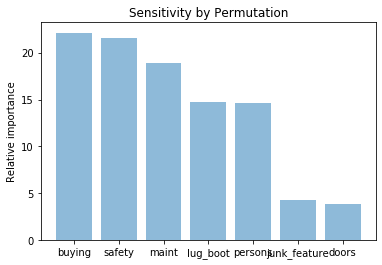

In [25]:
#@title Model sensitivity report { run: "auto" }

df=pd.DataFrame()
n=4
alg='Permutation' #@param['Permutation', 'NA value']

sens=None

while (True):
    try:
        sens = firefly.Ensemble.get_model_sensitivity_report(id=ensemble_id)
        if sens is not None:
            break
        time.sleep(5)
    except Exception as e:
        print(e)
        break
    
sensp=sens[alg]

df['features']=sensp.keys()
df['importance']=sensp.values()

df=df.sort_values(by='importance', ascending=False)

print("Top {0} important features by {1}:".format(n, alg))

pprint.pprint(df[:n].set_index('features'))


y_pos = np.arange(len(df.features))

plt.bar(y_pos, df['importance'], align='center', alpha=0.5)
plt.xticks(y_pos, df.features)
plt.ylabel('Relative importance')
plt.title('Sensitivity by {0}'.format(alg))

plt.show()

In [0]:
#@title Running predictions

#@markdown * upload predict data
df_pred = pd.read_csv(PATH+data_name+"_test.csv")
data_id=firefly.Datasource.create_from_dataframe(df=df_pred, data_source_name=data_name+"_test.csv",wait=True, skip_if_exists=True)['id']

#@markdown * run prediction using firefly.Prediction.create
predict_id=firefly.Prediction.create(ensemble_id=ensemble_id, data_id=data_id, wait=True)['id']
   

In [26]:
#@title Download a prediction

predict_results=firefly.Prediction.get(predict_id)

download_url = predict_results['result_path']

if download_url is not None:
    df_predict = pd.read_csv(download_url) 
    pprint.pprint(df_predict.head(10))


   row_identifier y_pred  acc_proba  good_proba  unacc_proba  vgood_proba
0            1000  unacc        0.0    0.174939     0.784658     0.040403
1            1001  unacc        0.0    0.174939     0.784658     0.040403
2            1002  unacc        0.0    0.174939     0.784658     0.040403
3            1003  unacc        0.0    0.174939     0.784658     0.040403
4            1004  unacc        0.0    0.174939     0.784658     0.040403
5            1005  unacc        0.0    0.174939     0.784658     0.040403
6            1006  unacc        0.0    0.174939     0.784658     0.040403
7            1007  unacc        0.0    0.174939     0.784658     0.040403
8            1008  unacc        0.0    0.174939     0.784658     0.040403
9            1009  unacc        0.0    0.174939     0.784658     0.040403


In [0]:
least_important_features=list(df.sort_values(by='importance').features[-3:])
least_important_features

['persons', 'safety', 'buying']

In [0]:
# create a dataset without the 3 least important features

try:
    dataset_id = firefly.Datasource.prepare_data(
            datasource_id=source_id, 
            dataset_name=data_name+"_imp",
            target=target, 
            header=True, 
            not_used=least_important_features,
            wait=False, skip_if_exists=True,
            problem_type=Task_Type
#             sample_id=['buying']
    )['id']
    print(dataset_id)

except Exception as e:
    print(e)
    

In [0]:
#confsion example
conf=firefly.Ensemble.get_ensemble_confusion_matrix(id=ensemble_id)['result']

labels= conf[0]
array = conf[1:]
df_cm = pd.DataFrame(array, index = [i for i in labels],
                  columns = labels)
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, fmt='3',annot=True)

## delete task / dataset / datasource by name


In [0]:
# inventory
datasources = firefly.Datasource.list(search_term=data_name)['hits']
datasets = firefly.Dataset.list(search_term=data_name)['hits']
tasks = firefly.Task.list(search_term=data_name)['hits']

print("Found {} data sources, {} datasets, {} tasks with name {}".format(len(datasources), len(datasets), len(tasks), data_name))

Found 2 data sources, 1 datasets, 4 tasks with name car_sdk_demo


In [0]:
sure=input("Input 'Y' for deleting demo files and tasks:")

if sure=='Y':

  for d in datasources:
    firefly.Datasource.delete(d['id'])

  for d in datasets:
    firefly.Dataset.delete(d['id'])

  for d in tasks:
    firefly.Task.delete(d['id'])

[link text](https://)